# PREDICTING USER SWITCHES TO RENEWABLES IN AGE OF CONSUMER ENERGY CHOICE

This project will explore the following two sets of factors involved with energy choice.
* Logistics: net generation of renewable electricity, retail price of electricity overall, retail price of renewables electricity, and temperature
* Socioeconomics: attitude toward renewables, income

** Note that the following simplifications were made: only PV is considered within renewables and political affiliation is acting as a substitute for attitude toward renewables. 

In this code the following will be done:
* Simple manipulation on the data to bring it into a usable form and handle missing data
* Binary classification and evaluation of performance using accuracy 
* 10-fold logistic classification and evaluation of performance using accuracy and various metrics
* SVM using linear, polynomial and RBF kernels and evaluation of performance using accuracy

## Background

The smart grids of tomorrow will likely have renewable electricity generation deeply ingrained into local and national power systems, but even the grids of today allow for some flexibility in generation types. More and more, utility companies like ConEdison allow their customers to choose the sourcing of their electricity. In some cases this means simply paying a premium cost for the utility to purchase the equivalent of their monthly energy usage (or in some cases only 2% of it) from a 'green' generation company. However, advances in mandated competition in the electricity market have led to ConEdison and other utilities like them paving the way for "Consumer Energy Choice." Utility customers can select an Energy Service Company (ESCO) to be their sole provider of electricity. There is a plethora of 'green' energy providers boasting tremendous sales and theoretical reductions in CO_2 emmisions from customers switching to their services; however, what exactly causes a customer to switch to renewable energy, and at when does the cost premium outweigh the desire to help save the environment?

## The Data

There is a direct relationship between the cost difference of the electricity and the decision of a user to stick with non-renewable energy, but this is not a 100% correlation; there must be other factors involved - natural logistics and morality. While a more robust study may be able to survey and psychoanalzye the motives of individuals in regards to the environment with a sufficient number of people, this study does not. Instead, morality is simplified by the socioeconomic principles of income and political leaning on a larger scale of state averages. 

The data in this project is taken for the 50 states of the US and comes in 7 forms, from a variety of sources:

* Net generation of solar energy per state, per month of 2014 to 2018 aggregated uniquely from data found on http://eia.gov
        * in gigawatthours
* Average retail price of electricity overall, per state, per month of 2014 to 2018 aggregated uniquely from data found on http://eia.gov
        * in cents per kilowatthour
* Average retail price of solar-sourced electricity, obtained by modifying the previous data with a 1.4x mutiplier in cold months, 1.5x mutiplier in warm months, and 1.6x mutiplier in hot months
        * in cents per kilowatthour
* Average monthly temperature (duplicated each year) aggregated uniquely from individual datasets from each state from https://ncdc.noaa.gov
        * in degrees Farenheit
* Weights assigned to statewide political affiliations (duplicated for each month) based on ratio of republican candidates voted into election in the past 4 presidential elections, aggregated uniquely from the following heat map: https://en.wikipedia.org/wiki/File:Red_state,_blue_state.svg 
        * 25  = republican voted in 4 of 4 elections 
        * 50  = republican voted in 3 of 4 elections
        * 75  = republican voted in 2 of 4 elections
        * 100 = republican voted in 1 of 4 elections
        * 125 = republican voted in 0 of 4 elections
    * A study by Pew Research Center found that Deomcratic leaning individuals were consistently, over the course of 6 years, almost twice as likely to prioritize alternative energy sources
* Median household income per state (duplicated for each month) collected from https://www.kff.org/other/state-indicator/median-annual-income/
* 'Target variable' binary decision value where 0 means the user does not switch to renewable electricity and 1 means the user does switch to renewable electricity - generated by veiwing a heatmap of relative features for each state and performing logical guesses for each user response
    * A more robust study could survey costumers in each state to conclusively determine if they have switched to renewables.

With these datasets, there are 6 possible classes or features for each monthly datapoint of the target variable.

Therefore, the datasets come in the shape of 57 months of data for 50 states (57 rows by 50 columns), but in practice, the classifier model calls for one column of concatenated data from all feature datasets.

## Load & Resolving the Data

We begin by loading the standard modules.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

In [2]:
sol_gen = pd.read_excel('SOLAR_GEN.xlsx', index_col=0)
sol_gen.head()

,AL,AK,AZ,AR,CA,CO,CT,DE,FL,GA,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
2014-01-01,0.02315,NaN,33.69629,0.12731,126.18537,10.03841,2.52982,0.83602,3.41786,0.26580,...,0.00406,0.00228,4.93823,0.68603,1.26255,0.62190,0.78737,0.14680,0.33478,0.06938
2014-02-01,0.02426,NaN,33.30055,0.13276,130.72280,10.29080,2.91530,0.94783,3.53032,0.27478,...,0.00499,0.00262,5.11450,0.72807,1.39266,0.67230,1.36798,0.16293,0.40491,0.07766
2014-03-01,0.03375,NaN,43.13728,0.18195,190.62208,13.98164,3.92307,1.25192,4.54952,0.35472,...,0.00679,0.00354,6.50828,1.09228,1.89942,0.85536,1.85635,0.21784,0.61966,0.11089
2014-04-01,0.03807,NaN,46.13305,0.21121,209.54273,15.17826,4.30027,1.33628,4.94652,0.38095,...,0.00801,0.00383,7.65786,1.22064,2.32048,0.90227,2.62857,0.23657,0.70590,0.12557
2014-05-01,0.04114,NaN,49.69665,0.22273,235.74219,16.59517,4.79609,1.51299,5.22890,0.41931,...,0.00920,0.00424,8.38926,1.43383,2.55897,1.00050,3.00961,0.26282,0.76858,0.14005


Note that there is some missing data from the Alaskan solar generation (and other states) for various time periods. 

These gaps can be remedied using many methods. The method chosen for this project is to fill in all missing data labeled NaN (Not-a-Number) with the state's mean value.

In [3]:
sol_gen1 = sol_gen.fillna(sol_gen.mean())
sol_gen1.head()

,AL,AK,AZ,AR,CA,CO,CT,DE,FL,GA,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
2014-01-01,0.02315,0.100542,33.69629,0.12731,126.18537,10.03841,2.52982,0.83602,3.41786,0.26580,...,0.00406,0.00228,4.93823,0.68603,1.26255,0.62190,0.78737,0.14680,0.33478,0.06938
2014-02-01,0.02426,0.100542,33.30055,0.13276,130.72280,10.29080,2.91530,0.94783,3.53032,0.27478,...,0.00499,0.00262,5.11450,0.72807,1.39266,0.67230,1.36798,0.16293,0.40491,0.07766
2014-03-01,0.03375,0.100542,43.13728,0.18195,190.62208,13.98164,3.92307,1.25192,4.54952,0.35472,...,0.00679,0.00354,6.50828,1.09228,1.89942,0.85536,1.85635,0.21784,0.61966,0.11089
2014-04-01,0.03807,0.100542,46.13305,0.21121,209.54273,15.17826,4.30027,1.33628,4.94652,0.38095,...,0.00801,0.00383,7.65786,1.22064,2.32048,0.90227,2.62857,0.23657,0.70590,0.12557
2014-05-01,0.04114,0.100542,49.69665,0.22273,235.74219,16.59517,4.79609,1.51299,5.22890,0.41931,...,0.00920,0.00424,8.38926,1.43383,2.55897,1.00050,3.00961,0.26282,0.76858,0.14005


We now load the other dataframes and fill in NaN values (if any):

In [4]:
all_prices = pd.read_excel('PRICES.xlsx', index_col=0)
all_prices1 = all_prices.fillna(all_prices.mean())

sol_prices = pd.read_excel('SOLAR_PRICES.xlsx', index_col=0)
sol_prices1 = sol_prices.fillna(sol_prices.mean())

temperature = pd.read_excel('TEMPERATURE.xlsx', index_col=0)
temperature1 = temperature.fillna(temperature.mean())

politics = pd.read_excel('POLITICS.xlsx', index_col=0)
politics1 = politics.fillna(politics.mean())

income = pd.read_excel('INCOME.xlsx', index_col=0)
income1 = income.fillna(income.mean())

The data can be plotted now to check for any additional invalid values:

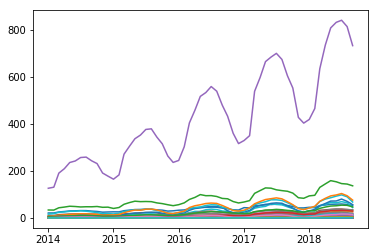

In [5]:
plt.plot(sol_gen1);

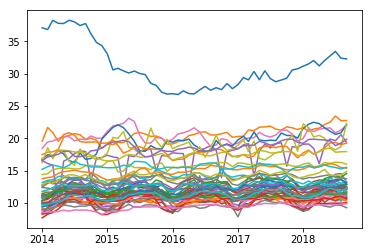

In [6]:
plt.plot(all_prices1);

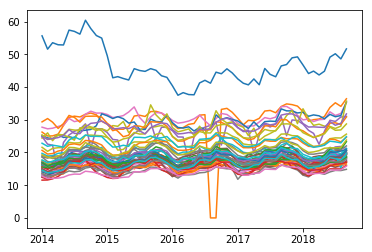

In [7]:
plt.plot(sol_prices1);

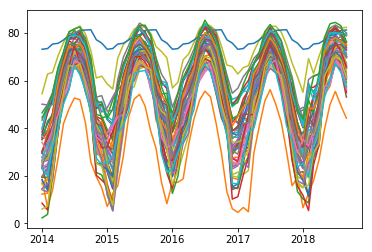

In [8]:
plt.plot(temperature1);

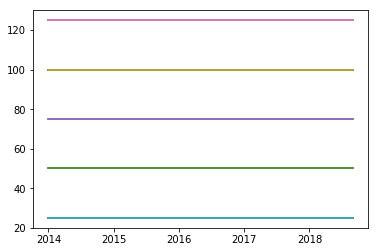

In [9]:
plt.plot(politics1);

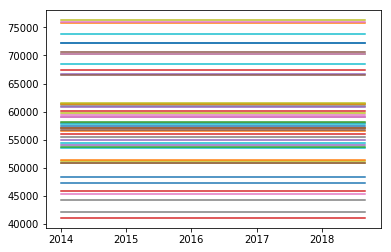

In [10]:
plt.plot(income1);

Similarly to the NaN values in solar generation, due to imperfections in the data, there is some data for the retail prices of electricity that is shown to have a value of 0. Of course in actuality there can never be an electricty price of $0, so these gaps must be filled similarly:

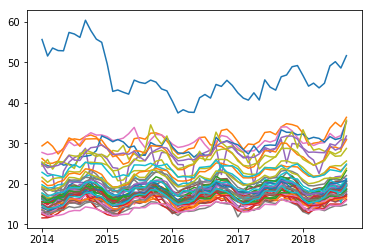

In [11]:
sol_prices2 = sol_prices.replace(0,sol_prices.mean())
plt.plot(sol_prices2);

## Manipulating the Data

The data directly from their sources is categorized by month and by state. Preserving this structure is not necessary for the pruposes of this project because the features of politics, temperature, and income are both based on the state and more relevant datapoints for predicting energy choice than just the state.

To operate binary classification, the data must be resructured so that rather than 57 rows of months and 50 columns of states for each feature, there are 57*50 rows of data (with 1 column) for each feature. Then the data for the 6 different features must be concatenated into a single array. 

In [12]:
sol_gen1_1 = sol_gen1.values.flatten()
all_prices1_1 = sol_gen1.values.flatten()
sol_prices2_1 = sol_gen1.values.flatten()
temperature1_1 = sol_gen1.values.flatten()
politics1_1 = sol_gen1.values.flatten()
income1_1 = sol_gen1.values.flatten()

income1_1.shape

(2850,)

Now there are six 1D feature arrays all with 50 * 57 = 2850 samples and they must be concatenated together to form the feature matrix:

In [13]:
X = np.vstack([sol_gen1_1,all_prices1_1,sol_prices2_1,temperature1_1,politics1_1,income1_1])

X.shape

(6, 2850)

The resulting array has 6 rows and 2850 columns, so the transpose of this array is the desired feature matrix

In [14]:
X1 = X.T

X1.shape

(2850, 6)

Next, the target data is loaded. This data is in the form of a binary decision variable, where:
* y_i = 0: user does not switch to renewable electricity
* y_i = 1: user does switch to renewable electricity

In [15]:
y = pd.read_excel('Y_SWITCH.xlsx', index_col=0)
y.head()

,AL,AK,AZ,AR,CA,CO,CT,DE,FL,GA,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
2014-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-01,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-03-01,0,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-04-01,0,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-05-01,0,0,0,0,1,1,1,1,1,0,...,0,0,0,1,1,1,0,0,0,0


The same reshaping is done on y:

In [16]:
y1 = y.values.flatten()

## Simple Logistic Regression

Now that the data is loaded for all 6 features and the target variable, logistic regression can be run on the data to fit the feature data to the target data.

In [17]:
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X1,y1)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Stored in this 'logreg' object is the predict function which predict the target variable using the linear regression model and trained data. Running the predicted target values and comparing them to the known target values yields the accuracy (the average similarity between the known and predicted target values) of the model: 

In [18]:
yhat1 = logreg.predict(X1)
accuracy1 = np.mean(yhat1==y1)
accuracy1

0.70631578947368423

## K-Fold Logistic Regression

It is important to note though that in this case the training data and the test data are one and the same. Therefore, it is recommended to perform k-fold cross-validation and randomly permute sets of training and test data. This is done with the sklearn.model_selection package that can be used to run the shuffle randomly with the argument 'shuffle=True'. In this case the shuffle is run with 10-fold cross-validation. This package also allows for the convinient retrieval of the precision, recall, and f1-score - and the error rate can be calculated by taking the average number of discrepencies between the known and the predicted target values over each fold:

In [19]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
prec = []
rec = []
f1 = []
err_rate = []

for Itr, Its in kf.split(X1):
    Xtr = X1[Itr,:]
    ytr = y1[Itr]
    Xts = X1[Its,:]
    yts = y1[Its]
    
    logreg.fit(Xtr, ytr)
    
    yhat = logreg.predict(Xts)
    
    preci,reci,f1i,_=precision_recall_fscore_support(yts,yhat,average='binary')
    
    prec.append(preci)
    rec.append(reci)
    f1.append(f1i)
    err_rate.append(np.mean(yts != yhat))
    
prec = np.mean(prec)
rec = np.mean(rec)
f1 = np.mean(f1)
err_mean = np.mean(err_rate)

print('Precision = {0:.4f}'.format(prec))
print('Recall = {0:.4f}'.format(rec))
print('f1 = {0:.4f}'.format(f1))
print('Error rate = {0:.4f}'.format(err_mean))

Precision = 0.6985
Recall = 0.1512
f1 = 0.2473
Error rate = 0.2940


Once again, the accuracy can be calculated for this model:

In [20]:
accuracy2 = np.mean(yhat==yts)
accuracy2

0.69473684210526321

## Support Vector Machines

In this algorithm, we plot each data item as a point in n-dimensional space (where n is number of features) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiate the two classes very well. In general, SVM is very good when there are many features, which is not the case in our dataset, but it shows that this model can be used when this problem is extended in the future on the avaibility of more relevant features. 

In [144]:
from sklearn import svm
svc = svm.SVC(probability=False,  kernel="linear", C=10, gamma=0.6, verbose=10)

Next, we get the training and test data. The features are re-scaled to be between -1 and 1.

In [145]:
nsamp = X1.shape[0]
Iperm = np.random.permutation(nsamp)

Xs = X1/255.0*2 - 1
ntr = int(X1.shape[0]/2)
nts = X1.shape[0] - ntr
Xtr = Xs[Iperm[:ntr],:]
ytr = y1[Iperm[:ntr]]
Xts = Xs[Iperm[ntr:ntr+nts],:]
yts = y1[Iperm[ntr:ntr+nts]]

In [146]:
svc.fit(Xtr,ytr)

[LibSVM]

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.6, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=10)

In [147]:
yhat_ts = svc.predict(Xts)

In [148]:
acc = np.mean(yhat_ts == yts)
print('Accuracy = {0:f}'.format(acc))

Accuracy = 0.727719


## SVM using the RBF kernel

In [149]:
C_test = [0.1,1,3,4,5,10]
gam_test = [0.009,0.001,0.01,0.6,0.5,0.4]
nC = len(C_test)
ngam = len(gam_test)
acc = np.zeros((nC,ngam))
cVals = np.zeros((nC,ngam))
gVals = np.zeros((nC,ngam))

#Measuring and printing the accuracy for each C and gamma value. 
for ci in range(nC):
    for gi in range(ngam):
        svci = svm.SVC(probability=False, kernel="rbf", C = C_test[ci], gamma = gam_test[gi]) 
        svci.fit(Xtr,ytr)
        yhat_tsi = svci.predict(Xts)
        acci = np.mean(yhat_tsi == yts)
        acc[ci,gi] = acci
        cVals[ci, gi] = C_test[ci]
        gVals[ci, gi] = gam_test[gi]

In [150]:
print(acc)

[[ 0.70315789  0.69122807  0.70385965  0.74736842  0.74596491  0.74526316]
 [ 0.70105263  0.70315789  0.70315789  0.74807018  0.74947368  0.75087719]
 [ 0.71719298  0.70245614  0.71719298  0.75298246  0.75017544  0.74947368]
 [ 0.71789474  0.70315789  0.72        0.75438596  0.75087719  0.75017544]
 [ 0.72350877  0.70315789  0.72421053  0.75368421  0.75017544  0.74947368]
 [ 0.73122807  0.70035088  0.73192982  0.75859649  0.75438596  0.75157895]]


In [151]:
ind = np.unravel_index(np.argmax(acc, axis = None),acc.shape)
ind0 = ind[0]
ind1 = ind[1]
cV = cVals[ind0][0]
gV = gVals[0][ind1]
print("The maximum accuracy is", np.amax(acc), "with C:", cV, "and gamma:", gV)

The maximum accuracy is 0.758596491228 with C: 10.0 and gamma: 0.6


## SVM using polynomial kernel of varying degrees

In [152]:
svcpoly = svm.SVC(probability=False,  kernel="poly", degree=2, verbose=10)
svcpoly.fit(Xtr,ytr)
yhat_ts = svcpoly.predict(Xts)

[LibSVM]

In [153]:
acc = np.mean(yhat_ts == yts)
print('Accuracy = {0:f}'.format(acc))

Accuracy = 0.697544


In [154]:
svcpoly = svm.SVC(probability=False,  kernel="poly", degree=3, verbose=10)
svcpoly.fit(Xtr,ytr)
yhat_ts = svcpoly.predict(Xts)

[LibSVM]

In [155]:
acc = np.mean(yhat_ts == yts)
print('Accuracy = {0:f}'.format(acc))

Accuracy = 0.749474


In [156]:
svcpoly = svm.SVC(probability=False,  kernel="poly", degree=4,verbose=10)
svcpoly.fit(Xtr,ytr)
yhat_ts = svcpoly.predict(Xts)
acc = np.mean(yhat_ts == yts)
print('Accuracy = {0:f}'.format(acc))

[LibSVM]Accuracy = 0.699649


In [157]:
svcpoly = svm.SVC(probability=False,  kernel="poly", degree=5, verbose=10)
svcpoly.fit(Xtr,ytr)
yhat_ts = svcpoly.predict(Xts)
acc = np.mean(yhat_ts == yts)
print('Accuracy = {0:f}'.format(acc))

[LibSVM]Accuracy = 0.701754


## Model Selection

Note that due to the limitations in the data and the synthetic nature of the known target values, accuracy is not drastically affected by model choice. However, if this practice is recreated for larger sample sizes, additional features, and real target data, the svm model is more ideal.